## Cell and spot segmentation

Goals:
1) Produce GT for cell segmentation by automatic detection of cells in green channel, potentially with a manual step to separate adjacent cells.
2) Train cell segmentation model by using the GT cells but now in the other channels (where all cells are visible, not only the mutated ones). Will need some kind of masked loss function since all cells per image have not been segmented.
3) Segment all cells with the model from step 2.
4) Produce GT for spot segmentation per cell level. When doing this per cell we can better control adjustments.
5) Train spot segmentation by using the GT spots.
6) Segment spots within cells using model from step 5.


Tested:
- Segmentation of cells in green channel in Labelbox: Just one click with the automatic hover&click tool and we get the outer contours if there are several adjacent green cells. The inner contours will not be possible to get like this, but manually drawing them would be fast. Possible workflow: 1) Automatic segmentation in Labelbox 2) manual drawing lines 3) find the new contours. Maybe we lose some of the work flow functionality in labelbox but otherwise this should be quite fast.
- Segmentation of spots in already segmented cell using SAM: We will need prompts, otherwise it segments random bodies and not the high intensity spots.
- Segmentation of spots in already segmented cell using intensity cut-off: Doesn't catch all spots since some have intensity overlap with the background.
- Segmentation of spots using several contours and filtering out non interesting object: This seems to work quite fine for producing GT but needs some manual tuning.

Questions:
- Would the LC3 signal be correlated to the cytosolic LC3 concentration? Otherwise the signal to noise ratio will change in autophagy active cells.
- What tool can we use to segment cells once we have GT? Some methods that allow for explainable methods would be nice! Perhaps we can learn something about the cell morphology.
- Can we fine-tune SAM once we have a red spot GT?
- Is there any point to think about explainable methods on spot segmentation? They are quite simple objects...

### The pipeline today:
- First spot segmentation using Cellpose.
- Then cell segmentation using Voronoi tesselations in ImageJ. This works ok but very sensitive to bad nuclei staining.
- Why do spot segmentation first? 
- What end metrics do they want to use? Any metrics on cell level or only average?

## Some testing

In [156]:
# imports 

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython import embed
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
import os
import numpy as np
import PIL
from PIL import Image
import torch
import pandas as pd
import tifffile
from cellpose import models, plot, utils, io
from cellpose.io import imread



In [130]:
# Functions for plotting

def tiff_to_array(tiff_path):
    with tifffile.TiffFile(tiff_path) as tiff:
        image = tiff.asarray() 
    return image

def crop(image, start_x, start_y, crop_size):
    crop_start_x = start_x
    crop_start_y = start_y
    image_cropped = image[crop_start_x:crop_start_x+crop_size,crop_start_y:crop_start_y+crop_size]
    return image_cropped

def plot_channels(img):
    # Plot all three channels
    vmax_factor =0.5
    plt.rcParams['figure.figsize'] = [10, 5] 
    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True)
    
    grey_cmap = LinearSegmentedColormap.from_list("", ["black","white"])
    max_green = np.max(img[:,:,0])
    max_red = np.max(img[:,:,0])
    max_blue = np.max(img[:,:,0])
    
    im1 = axes[0].imshow(img[:,:,0], cmap=grey_cmap, vmax = max_green)
    im2 = axes[1].imshow(img[:,:,1], cmap=grey_cmap, vmax = vmax_factor*max_red)
    im2 = axes[2].imshow(img[:,:,2], cmap=grey_cmap, vmax = vmax_factor*max_blue)
    
    axes[0].set_title('GFP (mutations)')
    axes[1].set_title('mCherry red (atg8a puncta)')
    axes[2].set_title('Dafi blue (nuclei)')
    
    fig.suptitle(image_name)
    
    plt.show()

# Convert one of the channels to three channel 8 bit image
def convert_img(img, channel):
    max_value = np.max(img[:,:,channel])
    img_8bit = (img[:,:,channel]/ max_value *255).astype('uint8')   
    new_image = np.repeat(img_8bit.reshape(2048, 2048, 1), 3, axis=2)
    return new_image

def plot_masks(original_img, masks):
    # Make transparent mask image
    #map_mask = sam_masks > 0
    #map_mask = np.dstack([map_mask]*3)
    #map_background = sam_masks == 0
    #map_background = np.dstack([map_background]*3)
    org_max = np.max(original_img)
        
    # plot masks and original image
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(masks, cmap='gray')
    axs[0].set_title('SAM masks')
    axs[1].imshow(original_img, cmap='gray', vmax = org_max)
    axs[1].set_title('Original image')
    axs[2].imshow(original_img, cmap='gray', vmax = org_max)
    axs[2].contour(masks*1,levels=[0.5])
    axs[2].set_title('Contours')
    plt.savefig('sam_masks.png')

def plot_threshold_masks(original_img, masks):
    # plot masks and original image
    plt.rcParams['figure.figsize'] = [10, 5] 
    fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
    im1= axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title('Original image')
    im2 = axs[1].imshow(original_img, cmap='gray')
    axs[1].contour(masks*1, levels=20) 
    axs[1].set_title('Contours')

    cbar = fig.colorbar(im1, ax=axes[1], shrink = 0.8)

In [158]:
 # Define mask generator for SAM model
MODEL_TYPE = "vit_l"
checkpoint_path = 'sam_vit_l_0b3195.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=checkpoint_path)
# #sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=500
)

### An example

 Below is the sample used in this notebook. The sample has only one visible mutated cell (left). The red channel with its puncta (middle) and the blue stained nuclei (right) are also shown. There is no far-red image. 

<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


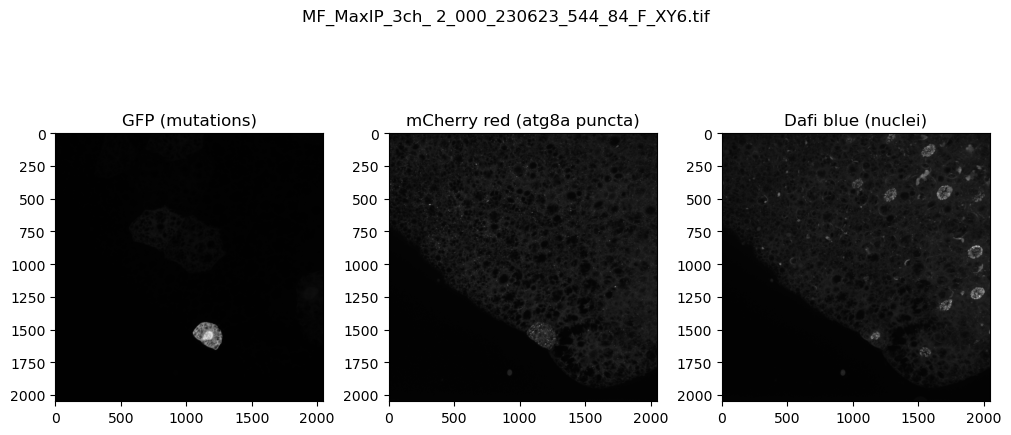

In [61]:
# get example image with only one mutant cell
image_name = 'MF_MaxIP_3ch_ 2_000_230623_544_84_F_XY6.tif'
cwd = os.getcwd()
image_path = cwd + '/Spot_segmentation_masks/' + image_name
img = tiff_to_array(image_path)

plot_channels(img)


### Cell segmentation in green channel

The whole image was used as an input to a SAM segmentation model. The parameters where taken from a tutorial, no parameter search was performed. In the image below, the masks produced by SAM are shown as a binary image (left), the original image (middle) and only the contours of the masks (right). 
- SAM seems to work well for finding the mutated cells, but with the settings used above it also finds those cells that emit little light (new mutants or autofluorescence).
- Probably labelbox is a good tool for doing this part since giving a prompt is probably a good idea but Labelbox will not be able to separate adjacent cells.

In [6]:
green_img = convert_img(img, 0)
cell_masks = mask_generator.generate(green_img)

# Save DataFrame to CSV file to use later
# = pd.DataFrame(sam_masks)
#df.to_csv('sam_masks_array.csv', index=False)

### All masks found by SAM

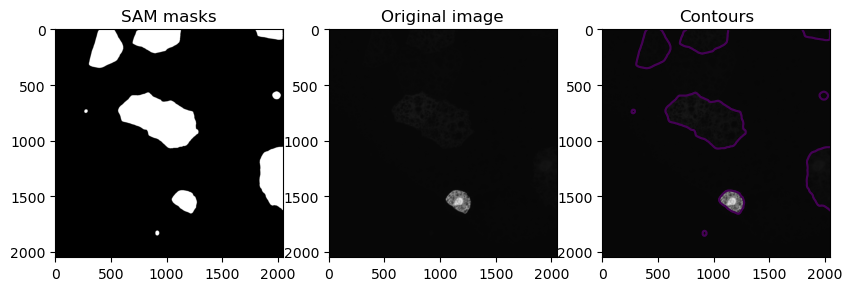

In [8]:
# Show all segmentations

image_size = 2048 # fixme would be better if not hardcoded
all_masks = np.zeros((image_size, image_size), dtype=bool)

for m, mask in enumerate(cell_masks):
    single_mask = mask['segmentation'] > 0
    all_masks = all_masks + single_mask
    # exclude the last mask that seems to cover the whole image
    if m == len(cell_masks)-2:
        break


plot_masks(green_img, all_masks)



### A close up on the mutated cell in green channel

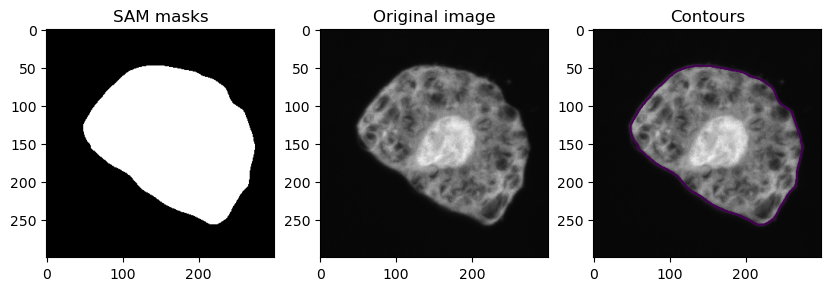

In [9]:
# Show only mutated cell segmentation

image_size = 2048 # fixme better if not hardcoded
img_mask = np.zeros((image_size, image_size), dtype=bool)

map_mask = cell_masks[0]['segmentation'] > 0
sam_masks = map_mask + img_mask

green_img_cropped = crop(green_img,1400, 1000, 300)
sam_masks_cropped = crop(sam_masks,1400, 1000, 300)

plot_masks(green_img_cropped, sam_masks_cropped)



### A close up on the mutated cell now in red channel

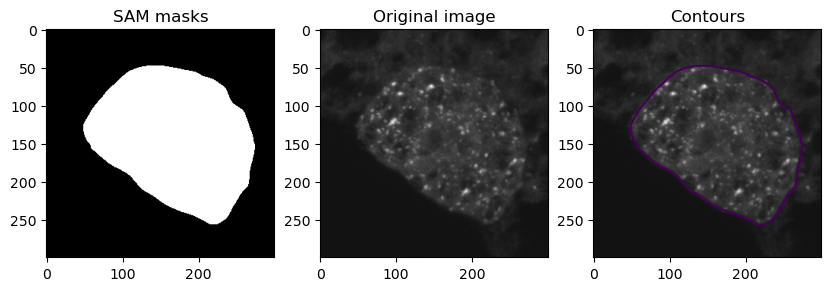

In [10]:
# Show the cell in the red channel
red_img = convert_img(img, 1)

image_size = 2048 # fixme better if not hardcoded
img_mask = np.zeros((image_size, image_size), dtype=bool)

map_mask = cell_masks[0]['segmentation'] > 0
sam_masks = map_mask + img_mask

red_img_cropped = crop(red_img,1400, 1000, 300)
sam_masks_cropped = crop(sam_masks,1400, 1000, 300)

plot_masks(red_img_cropped, sam_masks_cropped)



### The Cellpose spot segmentation
This is the spot segmentation of the same image performed by the bio group in Cellpose. 
- Not too bad inside the mutated cell (where both spots and background have higher intensities) but some spots are still missing
- There are probably fewer spots in the cells around, but also they seem to be harder to detect. They may be too similar to background when looking at all cells at once, could perhaps perform better if done per (normalised) cell

<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


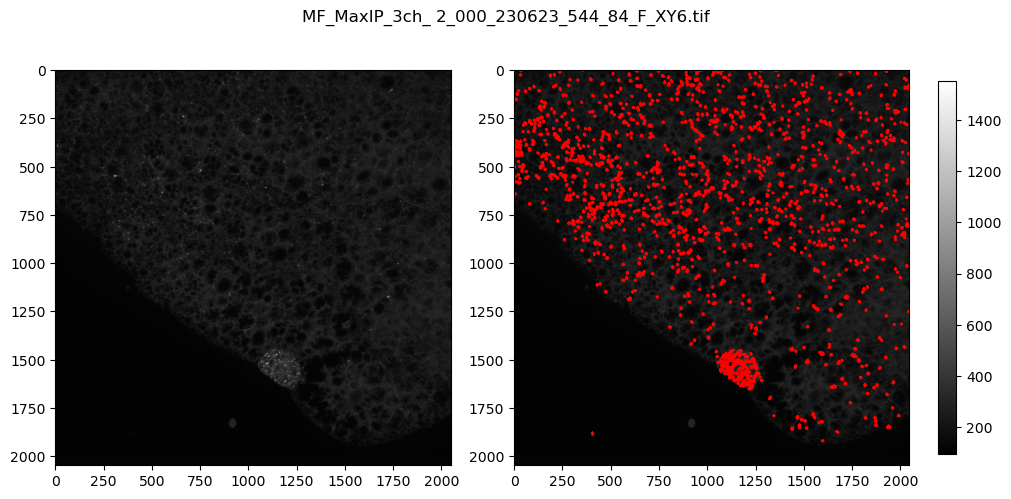

In [160]:
# get image 
image_name = 'MF_MaxIP_3ch_ 2_000_230623_544_84_F_XY6.tif'
cwd = os.getcwd()
image_path = cwd + '/Spot_segmentation_masks/' + image_name
img = io.imread(image_path)

# load masks
dat_path = image_path[:-4] + '_seg.npy'
dat = np.load(dat_path, allow_pickle=True).item()

# crop images and get contours
img = crop(img[:,:,1],0, 0, 2048)
masks =  crop(dat['masks'],0, 0, 2048)
outlines = utils.outlines_list(masks)

#  plot image with outlines overlaid in red
plt.rcParams['figure.figsize'] = [10, 5] 
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

im1 = axes[0].imshow(img, cmap=grey_cmap)
for o in outlines: 
    plt.plot(o[:,0], o[:,1], color='r')
im2 = axes[1].imshow(img, cmap='gray')
cbar = fig.colorbar(im1, ax=axes[1], shrink = 0.8)

fig.suptitle(image_name)
plt.show()

### Close up on the mutated cell


<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


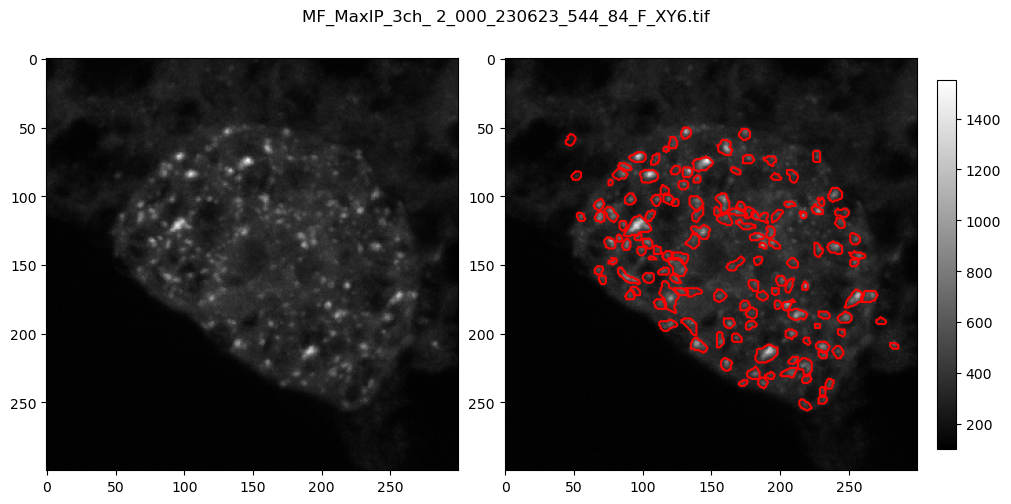

In [110]:
# get image 
image_name = 'MF_MaxIP_3ch_ 2_000_230623_544_84_F_XY6.tif'
cwd = os.getcwd()
image_path = cwd + '/Spot_segmentation_masks/' + image_name
img = io.imread(image_path)

# load masks
dat_path = image_path[:-4] + '_seg.npy'
dat = np.load(dat_path, allow_pickle=True).item()

# crop images and get contours
img = crop(img[:,:,1],1400, 1000, 300)
masks =  crop(dat['masks'],1400, 1000, 300)
outlines = utils.outlines_list(masks)

#  plot image with outlines overlaid in red
plt.rcParams['figure.figsize'] = [10, 5] 
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

im1 = axes[0].imshow(img, cmap=grey_cmap)
for o in outlines: 
    plt.plot(o[:,0], o[:,1], color='r')
im2 = axes[1].imshow(img, cmap='gray')
cbar = fig.colorbar(im1, ax=axes[1], shrink = 0.8)

fig.suptitle(image_name)
plt.show()

### Even more close up to see the contours of the masks
- Some spots are very close to resoultion limit. Since all spots start small and grow, there will always be a size cut-off. The smallest spot will add to the background noise.


<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


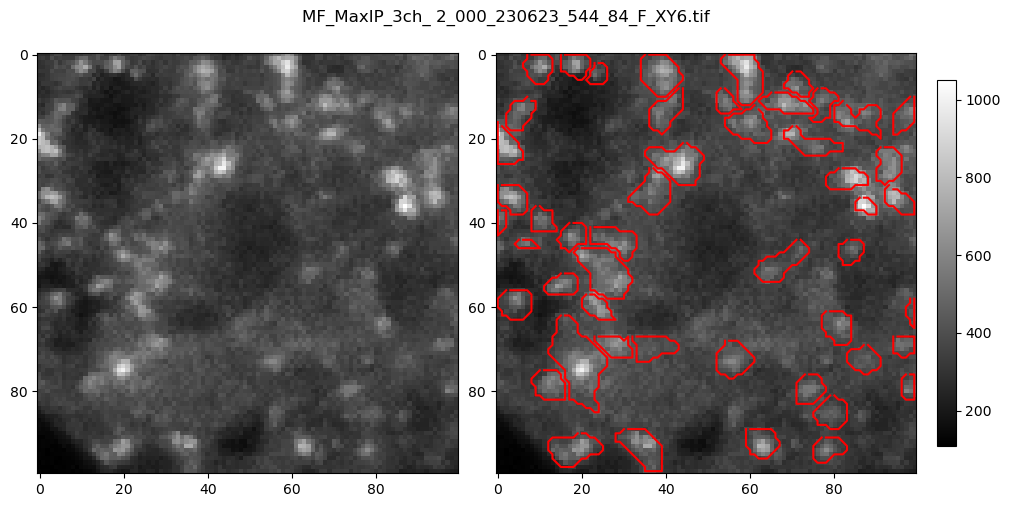

In [121]:
# get image 
image_name = 'MF_MaxIP_3ch_ 2_000_230623_544_84_F_XY6.tif'
cwd = os.getcwd()
image_path = cwd + '/Spot_segmentation_masks/' + image_name
img = io.imread(image_path)

# load masks
dat_path = image_path[:-4] + '_seg.npy'
dat = np.load(dat_path, allow_pickle=True).item()
# crop images and get contours
img = crop(img[:,:,1],1500, 1100, 100)
masks =  crop(dat['masks'],1500, 1100, 100)
outlines = utils.outlines_list(masks)

#  plot image with outlines overlaid in red
plt.rcParams['figure.figsize'] = [10, 5] 
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

im1 = axes[0].imshow(img, cmap=grey_cmap)
for o in outlines: 
    plt.plot(o[:,0], o[:,1], color='r')
im2 = axes[1].imshow(img, cmap='gray')
cbar = fig.colorbar(im1, ax=axes[1], shrink = 0.8)

fig.suptitle(image_name)
plt.show()

In [12]:
# get example image with only one mutant cell
image_name = 'MF_MaxIP_3ch_ 2_000_230623_544_84_F_XY6.tif'
cwd = os.getcwd()
image_path = cwd + '/Spot_segmentation_masks/' + image_name
img = tiff_to_array(image_path)

red_img = convert_img(red_img, 1)
red_img_cropped = crop(red_img,1400, 1000, 300)
cell_mask_cropped = crop(sam_masks,1400, 1000, 300)
cell_mask_cropped = np.dstack([cell_mask_cropped]*3)
masked_cell = cell_mask_cropped * red_img_cropped



<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


In [ ]:
spot_masks = mask_generator.generate(masked_cell)

### Try to segment cells by using intensity threshold

Trying to find a threshold that divides background from spots and use this to perform segmentation. First, checking the histogram to find a reasonable pixel value to use a cut-off.
- Doesn't work well since background and spot pixel values overlap. The background is not constant, so a low intensity spot can still be distinguished in areas with even lower background intensity.
- Also some of the spots are very small, getting into resolution problem.
- BUT even a spot containing few pixels with "just above background pixel value" can be distinguished with the eye.

<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


<function matplotlib.pyplot.show(close=None, block=None)>

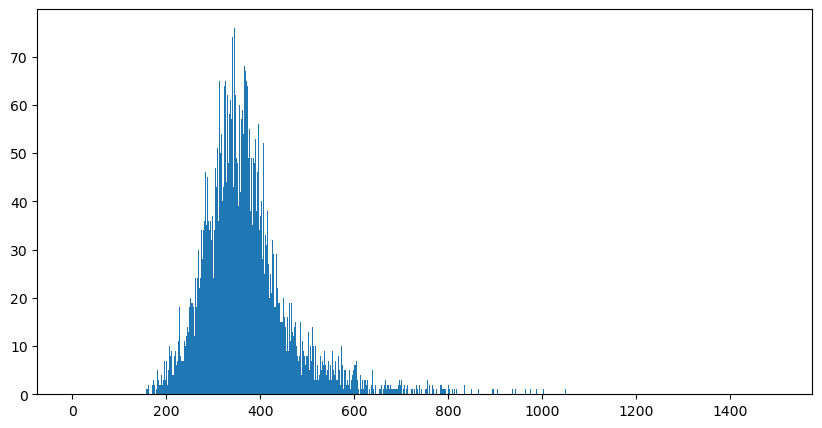

In [115]:
img = tiff_to_array(image_path)
red_img = img[:,:,1]
red_img_cropped = crop(red_img,1500, 1100, 100)
cell_mask_cropped = crop(sam_masks,1500, 1100, 100)
cell_mask_cropped = np.dstack([cell_mask_cropped]*3)
masked_cell = cell_mask_cropped[:,:,0] * red_img_cropped
masked_cell_flat = masked_cell.flatten()
plt.hist(masked_cell_flat, bins = 1500, range= (1,1500))
plt.show

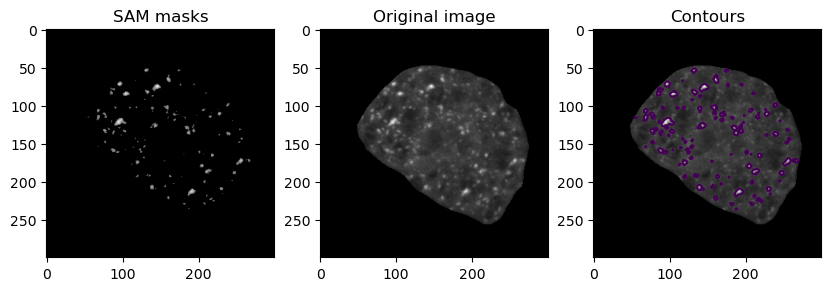

In [56]:
filter = masked_cell > 600
int_masks = filter*masked_cell
plot_threshold_masks(masked_cell, int_masks )

### Some zooms just to see better

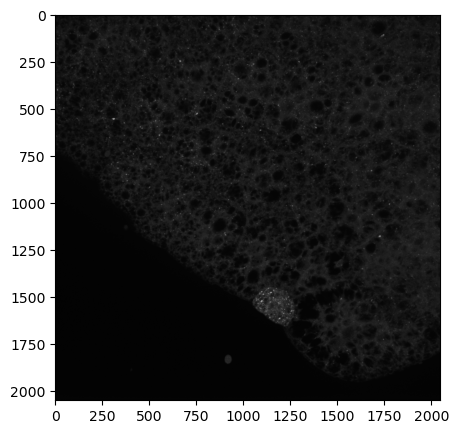

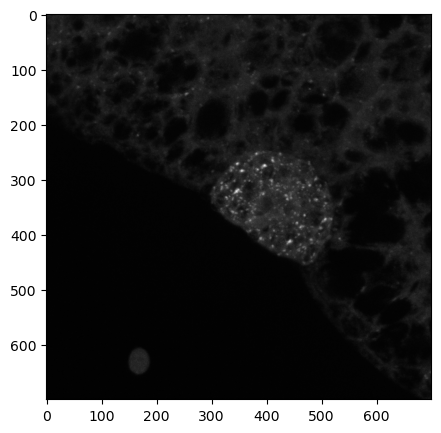

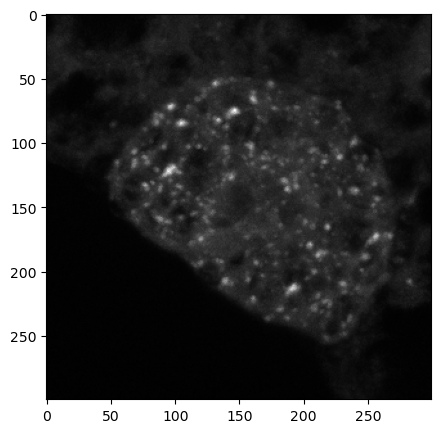

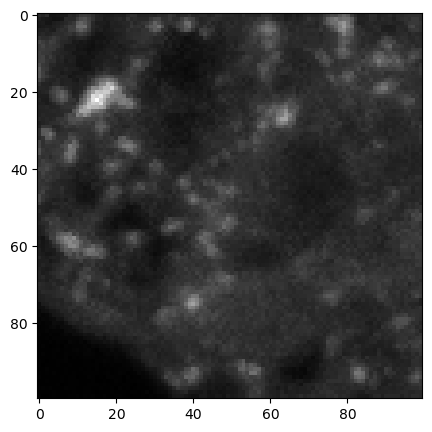

In [88]:
red_img_1 = crop(red_img,0, 0, 2048)
red_img_2 = crop(red_img,1200, 750 , 700)
red_img_3 = crop(red_img,1400, 1000, 300)
red_img_4 = crop(red_img,1500, 1080, 100)
fig1 = plt.imshow(red_img_1, cmap='gray')
plt.show()
fig2 = plt.imshow(red_img_2, cmap='gray')
plt.show()
fig3 = plt.imshow(red_img_3, cmap='gray')
plt.show()
fig4 = plt.imshow(red_img_4, cmap='gray')
plt.show()

### Comparing threshold method to Cellpose
- Cellpose perfoms better but still misses some spots
- Cellpose has a tendency to merge spots

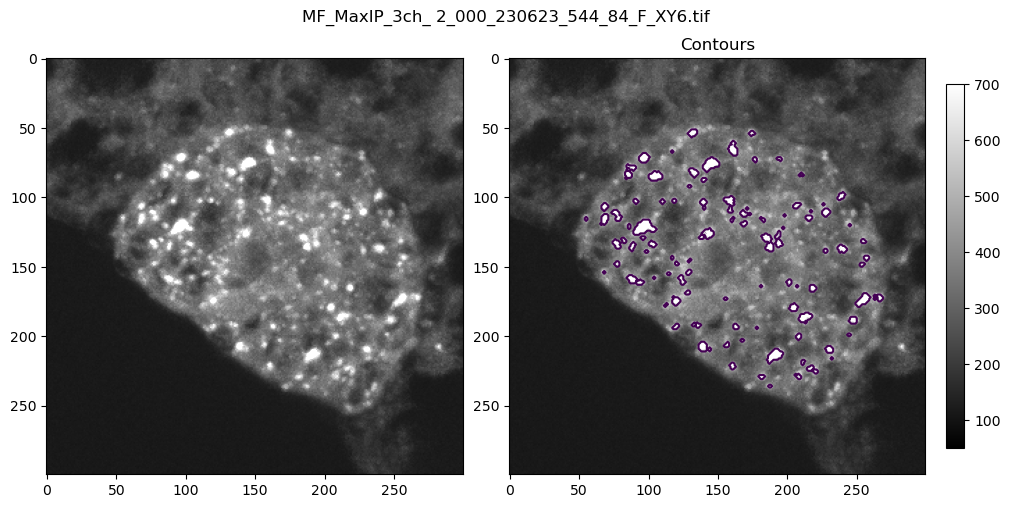

In [57]:
red_img_cropped = crop(red_img,1400, 1000, 300)

#  plot image with outlines overlaid in red
plt.rcParams['figure.figsize'] = [10, 5] 
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

grey_cmap = LinearSegmentedColormap.from_list("", ["black","white"])
max_red = np.max(red_img)

im1 = axes[0].imshow(red_img_cropped, cmap=grey_cmap, vmin = 50, vmax = 700)
im2 = axes[1].imshow(red_img_cropped, cmap=grey_cmap, vmin = 50, vmax = 700)
axes[1].contour(int_masks,levels=[0.5])
cbar = fig.colorbar(im1, ax=axes[1], shrink = 0.8)

    
axes[1].set_title('Contours')

fig.suptitle(image_name)
plt.show()

<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


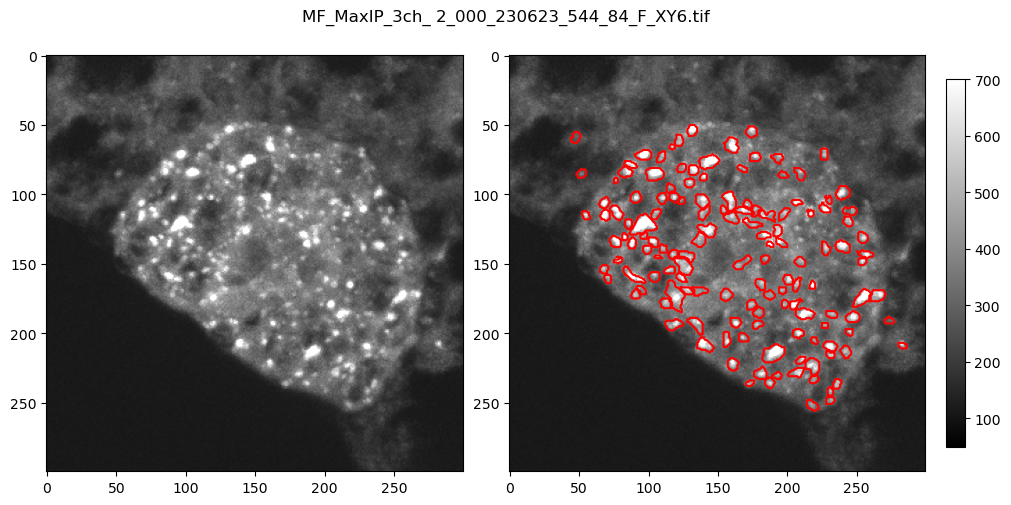

In [50]:
image_name = 'MF_MaxIP_3ch_ 2_000_230623_544_84_F_XY6.tif'
cwd = os.getcwd()
image_path = cwd + '/Spot_segmentation_masks/' + image_name
#img = tiff_to_array(image_path)


vmax_factor = 0.2


img = io.imread(image_path)
dat_path = image_path[:-4] + '_seg.npy'
dat = np.load(dat_path, allow_pickle=True).item()
# plot image with masks overlaid
mask_RGB = plot.mask_overlay(img[:,:,1], dat['masks'],
                        colors=np.array(dat['colors']))

# crop images and get contours
img = crop(img[:,:,1],1400, 1000, 300)
masks =  crop(dat['masks'],1400, 1000, 300)
outlines = utils.outlines_list(masks)

#  plot image with outlines overlaid in red
plt.rcParams['figure.figsize'] = [10, 5] 
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

grey_cmap = LinearSegmentedColormap.from_list("", ["black","white"])
max_red = np.max(img)

im1 = axes[0].imshow(img, cmap=grey_cmap, vmin =50, vmax = 700)
for o in outlines: 
    plt.plot(o[:,0], o[:,1], color='r')
im2 = axes[1].imshow(img, cmap=grey_cmap, vmin = 50, vmax = 700)
cbar = fig.colorbar(im1, ax=axes[1], shrink = 0.8)

fig.suptitle(image_name)
plt.show()



### Now introducing layers in the thresholding
- When using the countour function in matplotlib you can choose the number of levels.
- Assumption: Our spots have a radial intensity pattern with peak values in the middle.
- The spots appear as colored dots as several contours are stacked on the top of each other.
- The spots are seen independently of their peak intensity, only gradient is important.
- The dots must be filtered to only get the right ones: remove dark spots, small dots, irregular shapes etc.


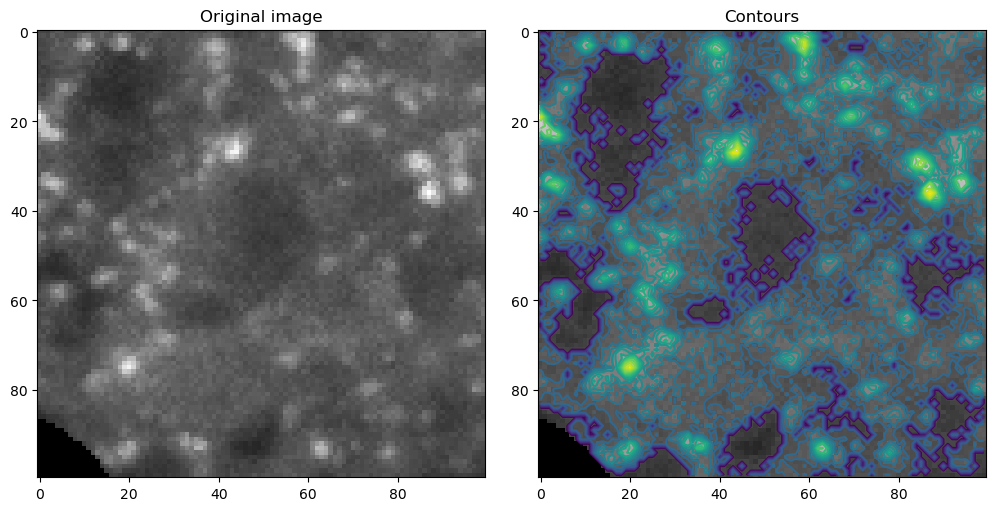

In [141]:
filter = masked_cell > 300
int_masks = filter*masked_cell
plot_threshold_masks(masked_cell, int_masks )
#plot_threshold_masks(filter, int_masks )

### Trying SAM to get the dots
I also tried to run the same SAM model as above but now on the segmented cell to see if it could detect the dots. It finds different things to segment but it clearly needs promts to perform well.
- SAM without prompts was giving poor results.
- Didn't try to change parameters, could perhaps be optimised.



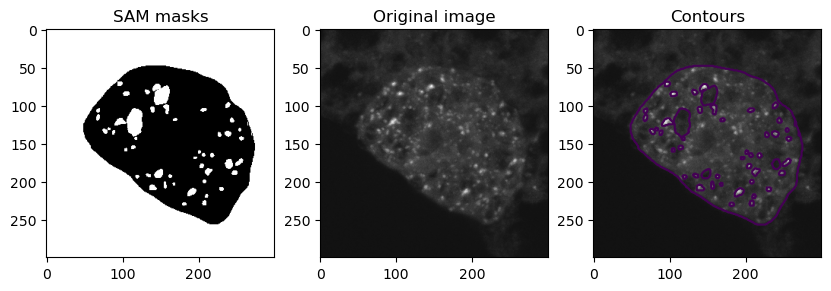

In [183]:
# Show all segmentations

image_size = 300 # fixme would be better if not hardcoded
all_masks = np.zeros((image_size, image_size), dtype=bool)

for m, mask in enumerate(spot_masks):
    if m != 1:

        single_mask = mask['segmentation'] > 0
    
        all_masks = all_masks + single_mask
    # exclude the last mask that seems to cover the whole image
    


plot_masks(red_img_cropped, all_masks)

### Possible solution
Since the spots are simple objects, defined by a radial gradient, they could be found automaticaly without using machine learning tools. The results below are found by using the contour function in matplotlib and then systematically removing contours that are not interesting. It is small code snippet that I have tested but it is unfortunately not open source so I would need some time to reproduce it.

- The method finds all dots with a radial pattern, so it should theoretically find all spots. Then the challenge is to filter out the non interesting contours without loosing the ones we want. 
- It should be considered a feature detecting tool more than a segmentation tool, even if it could be used for segmentation.
- Afterwards, the spots could be segmented by SAM using prompts from the above method. Since SAM is made to segment things, it may get the contours better.
- Once we have some GT cells with spots, can we fine-tune SAM so that we don't need to use the matplotlib method anymore?



<tifffile.TiffFile 'MF_MaxIP_3ch_ 2…544_84_F_XY6.tif'> OME series cannot handle discontiguous storage ((2048, 2048, 3) != (3, 2048, 2048))


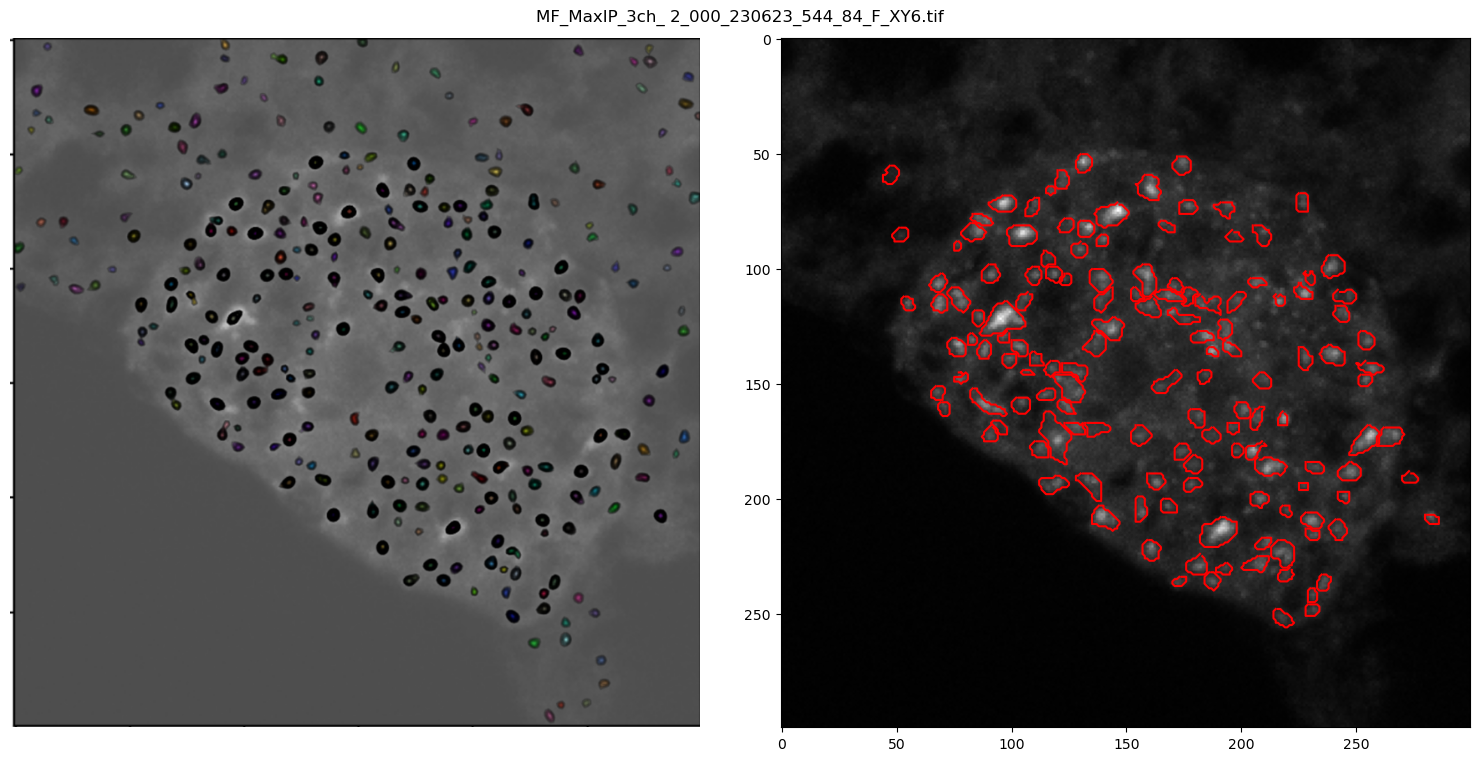

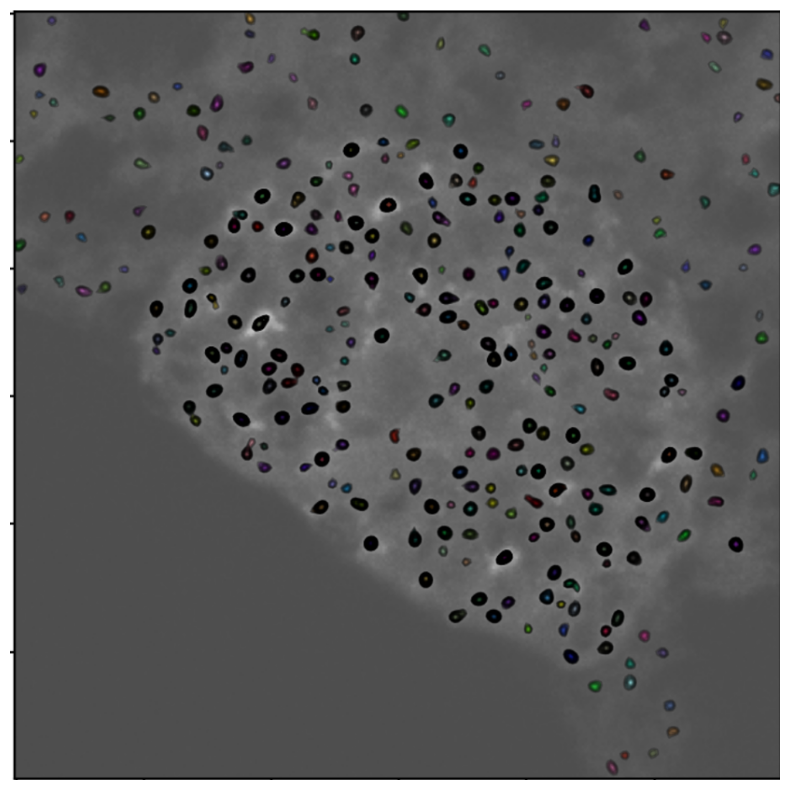

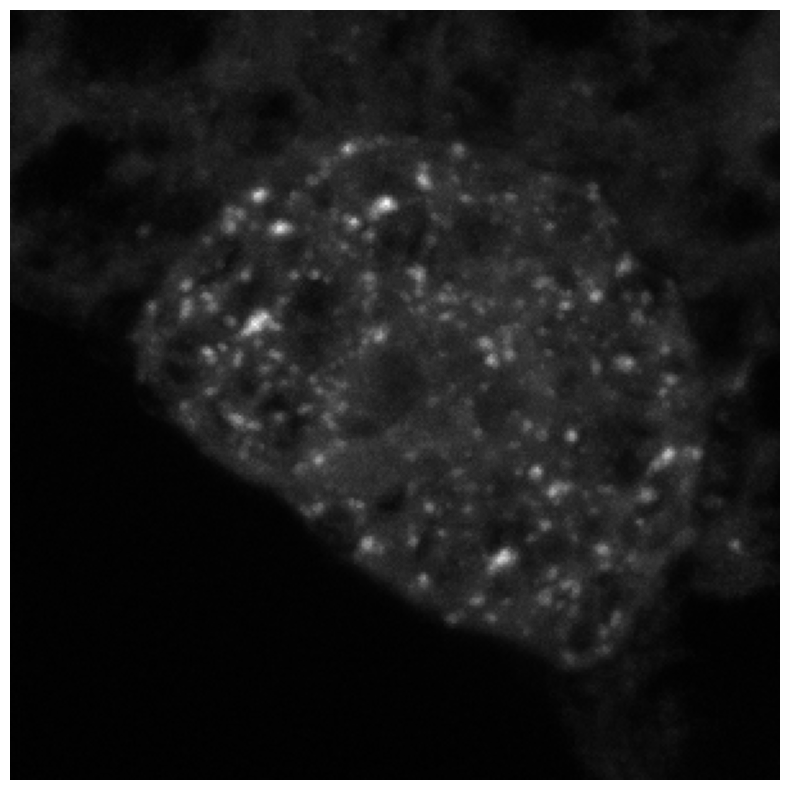

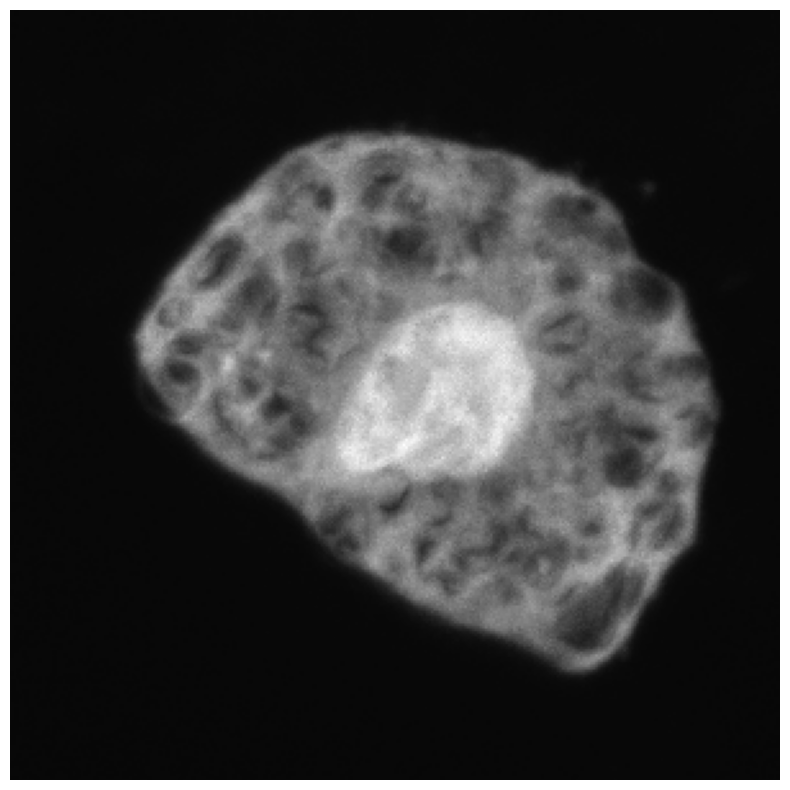

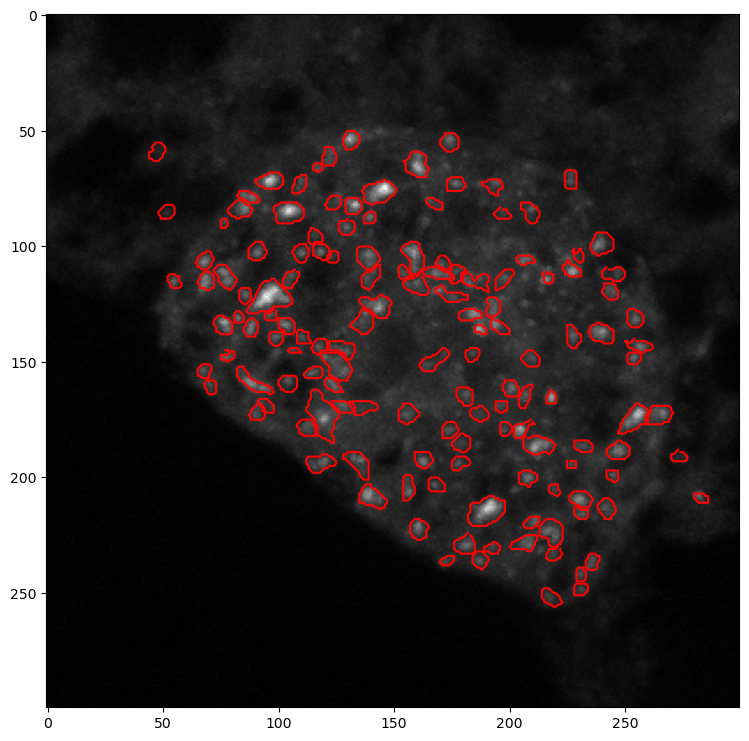

In [167]:
# get image 
image_name = 'MF_MaxIP_3ch_ 2_000_230623_544_84_F_XY6.tif'
cwd = os.getcwd()
image_path = cwd + '/Spot_segmentation_masks/' + image_name
img = io.imread(image_path)

# get countour map image
img_ctrs = Image.open('local_max_by_ctrs_cropped_small.png')

# load masks
dat_path = image_path[:-4] + '_seg.npy'
dat = np.load(dat_path, allow_pickle=True).item()

# crop images and get contours
img = crop(img[:,:,1],1400, 1000, 300)
masks =  crop(dat['masks'],1400, 1000, 300)
outlines = utils.outlines_list(masks)

#  plot image with outlines overlaid in red
plt.rcParams['figure.figsize'] = [15, 7.5] 
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

im1 = axes[0].imshow(img_ctrs, cmap=grey_cmap, aspect='equal')
for o in outlines: 
    plt.plot(o[:,0], o[:,1], color='r')
im2 = axes[1].imshow(img, cmap='gray')
axes[0].axis('off')
fig.suptitle(image_name)
plt.show()

plt.rcParams['figure.figsize'] = [10, 10] 
#fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

fig1 = plt.imshow(img_ctrs, cmap=grey_cmap, aspect='equal')
plt.axis('off')
plt.show()

plt.rcParams['figure.figsize'] = [10, 10] 
#fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

fig1 = plt.imshow(red_img_cropped, cmap=grey_cmap, aspect='equal')
plt.axis('off')
plt.show()

plt.rcParams['figure.figsize'] = [10, 10] 
#fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

fig1 = plt.imshow(green_img_cropped, cmap=grey_cmap, aspect='equal')
plt.axis('off')
plt.show()

plt.rcParams['figure.figsize'] = [9, 9] 
for o in outlines: 
    plt.plot(o[:,0], o[:,1], color='r')
fig2 = plt.imshow(img, cmap='gray')


fig.suptitle(image_name)
plt.show()